## Transfer Learning VGG 16 using Keras

In [1]:
!nvidia-smi

Fri Mar 10 10:04:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ROOT_PATH = '/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project'

In [6]:
!pwd

/content


In [7]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project'

In [38]:
!ls

 AccVal_acc.png		   dog.jpg	      model_vgg16.h5
'Cat-Dog by VGG16.ipynb'   LossVal_loss.png   PetImages


In [9]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'PetImages/train'
valid_path = 'PetImages/validation'


In [10]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In [11]:
# don't train existing weights
for layer in vgg16.layers:
  print(layer)

In [12]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [13]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [14]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
  # useful for getting number of output classes
folders = glob('PetImages/train/*')

In [16]:
folders

['PetImages/train/Dog', 'PetImages/train/Cat']

In [17]:
len(folders)

2

In [18]:
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [19]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [21]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
!pwd

/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS-Bootcamp/cat-dog-project


In [23]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('PetImages/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 337 images belonging to 2 classes.


In [24]:
test_set = test_datagen.flow_from_directory('PetImages/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 59 images belonging to 2 classes.


In [25]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
11/11 [==============================] - 62s 5s/step - loss: 4.0096 - accuracy: 0.5638 - val_loss: 2.4686 - val_accuracy: 0.5085
Epoch 2/10
11/11 [==============================] - 5s 413ms/step - loss: 0.6677 - accuracy: 0.7982 - val_loss: 1.4763 - val_accuracy: 0.6949
Epoch 3/10
11/11 [==============================] - 5s 412ms/step - loss: 0.5414 - accuracy: 0.8516 - val_loss: 0.8553 - val_accuracy: 0.8305
Epoch 4/10
11/11 [==============================] - 5s 413ms/step - loss: 0.2203 - accuracy: 0.9288 - val_loss: 0.6269 - val_accuracy: 0.8136
Epoch 5/10
11/11 [==============================] - 5s 414ms/step - loss: 0.1255 - accuracy: 0.9525 - val_loss: 0.5874 - val_accuracy: 0.7966
Epoch 6/10
11/11 [==============================] - 5s 416ms/step - loss: 0.1294 - accuracy: 0.9496 - val_loss: 0.5694 - val_accuracy: 0.7966
Epoch 7/10
11/11 [==============================] - 5s 411ms/step - loss: 0.0684 - accuracy: 0.9822 - val_loss: 0.5689 - val_accuracy: 0.8136
Epoch 8/

In [26]:
import matplotlib.pyplot as plt

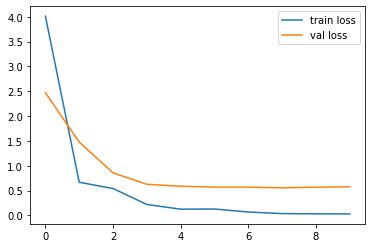

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

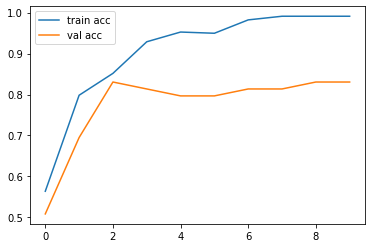

<Figure size 432x288 with 0 Axes>

In [28]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [29]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [30]:
y_pred = model.predict(test_set)

2/2 [==============================] - 0s 97ms/step


In [31]:
y_pred

array([[9.9802399e-01, 1.9760912e-03],
       [9.9340135e-01, 6.5986682e-03],
       [2.4365056e-02, 9.7563499e-01],
       [6.2193606e-02, 9.3780643e-01],
       [8.3583437e-02, 9.1641659e-01],
       [9.9998772e-01, 1.2298901e-05],
       [4.3993664e-04, 9.9956006e-01],
       [2.3524357e-12, 1.0000000e+00],
       [6.5959990e-01, 3.4040010e-01],
       [9.9999678e-01, 3.2618991e-06],
       [9.9155223e-01, 8.4477914e-03],
       [9.6670803e-05, 9.9990332e-01],
       [1.5993884e-02, 9.8400611e-01],
       [9.9999988e-01, 1.7733669e-07],
       [1.2521014e-01, 8.7478983e-01],
       [9.4045329e-01, 5.9546757e-02],
       [9.3856788e-01, 6.1432153e-02],
       [4.8552232e-07, 9.9999952e-01],
       [4.7090880e-04, 9.9952912e-01],
       [3.7821671e-08, 1.0000000e+00],
       [8.1671768e-01, 1.8328229e-01],
       [1.0619577e-05, 9.9998939e-01],
       [1.4204809e-03, 9.9857950e-01],
       [7.5302587e-04, 9.9924695e-01],
       [1.7833519e-05, 9.9998212e-01],
       [8.3583432e-01, 1.

In [32]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [33]:
y_pred

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1])

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [35]:
model=load_model('model_vgg16.h5')

In [73]:
img=image.load_img('cat.jpg',target_size=(224,224))

In [74]:
x=image.img_to_array(img)
x

array([[[ 36.,  41.,  37.],
        [ 38.,  42.,  41.],
        [ 38.,  42.,  43.],
        ...,
        [200., 200., 166.],
        [200., 198., 160.],
        [203., 201., 162.]],

       [[ 38.,  43.,  39.],
        [ 39.,  43.,  42.],
        [ 40.,  44.,  45.],
        ...,
        [208., 205., 172.],
        [205., 203., 165.],
        [204., 202., 163.]],

       [[ 42.,  47.,  43.],
        [ 40.,  44.,  43.],
        [ 40.,  44.,  45.],
        ...,
        [201., 198., 167.],
        [201., 196., 164.],
        [197., 193., 158.]],

       ...,

       [[ 30.,  28.,  29.],
        [ 24.,  22.,  23.],
        [ 21.,  19.,  20.],
        ...,
        [ 47.,  34.,  28.],
        [ 40.,  27.,  21.],
        [ 52.,  41.,  35.]],

       [[ 34.,  32.,  33.],
        [ 27.,  25.,  26.],
        [ 24.,  22.,  23.],
        ...,
        [ 45.,  32.,  24.],
        [ 44.,  31.,  23.],
        [ 65.,  55.,  46.]],

       [[ 30.,  28.,  29.],
        [ 26.,  24.,  25.],
        [ 24.,  

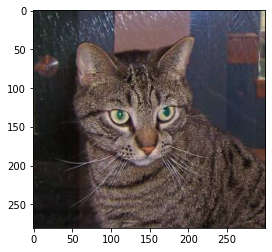

In [70]:
Z = plt.imread('cat.jpg')
plt.imshow(Z)

In [75]:
x.shape

(224, 224, 3)

In [76]:
x=x/255

In [77]:
from keras.applications.vgg16 import preprocess_input

In [78]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [79]:
model.predict(img_data)

1/1 [==============================] - 0s 27ms/step


array([[9.9998105e-01, 1.8916740e-05]], dtype=float32)

In [80]:
result = np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 23ms/step


In [81]:
result[0]

0

In [82]:
if result[0] == 1:
    prediction = 'dog'
    print(prediction)
else:
    prediction = 'cat'
    print(prediction)

cat
